In [36]:
import tensorflow as tf
import torch 
import Bio.SeqIO as SeqIO
from transformers import BertTokenizer, BertForSequenceClassification
import pickle
import random
import numpy as np
import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

2024-01-21 10:34:33.630298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 10:34:34.594684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the trained Hybrid NN

In [2]:
# Load the models
all_seq_NN = tf.keras.models.load_model('/data/xhorvat9/ltr_bert/NewClassifiers/Superfamily/NN/all_length_cnn_lstm.h5') 

2024-01-20 20:16:06.118755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-20 20:16:06.120371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
2024-01-20 20:16:06.660325: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Load the finetuned DNABERT model

In [3]:
from utils.BERT_utils import *
KMER = 6
STRIDE_SIZE = 1

tokenizer = BertTokenizer.from_pretrained(f'zhihan1996/DNA_bert_6')
model = BertForSequenceClassification.from_pretrained("/data/xhorvat9/ltr_bert/NewClassifiers/Superfamily/BERT/LTRBERT_superfamily_512")
model.eval()

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


## Load the trained GB classifier

In [20]:
import pickle
GBC = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Superfamily/TFBS/GBC_pipeline.b", "rb"))

/var/tmp/xhorvat9/tf_CUDA/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/tmp/xhorvat9/tf_CUDA/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DummyClassifier from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/tmp/xhorvat9/tf_CUDA/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.0 when using

## Test on short sequences (within 512bps)

In [37]:
MAX_LEN=512
MIN_LEN=0

LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN and rec.description.split()[3] != "NAN"]
sequences = [str(rec.seq) for rec in LTRs]
labels = [rec.description.split()[3] for rec in LTRs]
le = LabelEncoder()
labels = list(le.fit_transform(labels))

### LTRBERT
- tokenize
- encode
- run predictions

In [8]:
from transformers import Trainer

model = model.to("cuda")
data = Dataset(tokenizer([tok_func(x, int(KMER), STRIDE_SIZE) for x in sequences], padding=True, truncation=True, max_length=512), labels)
trainer = Trainer(model)
raw_pred, _, _ = trainer.predict(data) # Preprocess raw predictions
BERT_short_predictions = np.argmax(raw_pred, axis=1)

/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [9]:
np.save("BERT_short_predictions.npy", BERT_short_predictions)
np.save("BERT_short_pred_probas.npy", raw_pred)

### CNN-LSTM
- encode
- pad
- run predictions

In [3]:
import numpy as np
from utils.CNN_utils import *

In [9]:
sequences = [onehote(remove_N(str(rec.seq))) for rec in tqdm.tqdm(LTRs)]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="pre", maxlen=3000)
Hybrid_NN_short_probas = all_seq_NN.predict(paddedDNA)
Hybrid_NN_short_predictions = ((Hybrid_NN_short_probas > 0.5)+0).ravel()

100%|██████████| 22696/22696 [00:05<00:00, 4397.11it/s]
2024-01-20 20:18:44.917018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-20 20:18:45.051421: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


710/710 [==============================] - 10s 13ms/step


In [10]:
np.save("NN_short_predictions.npy", Hybrid_NN_short_predictions)
np.save("NN_short_pred_probas.npy", Hybrid_NN_short_probas)

## GBC

In [12]:
import pickle
test_LTR_motifs = pickle.load(open("/data/xhorvat9/ltr_bert/Simple_ML_model/test_LTR_TFBS_old638.b", "rb"))

In [33]:
def get_presence_count_dict(motif_dict_count, motif_dict_presence, TF_sites):
    for seq in TF_sites:
        for motif in motif_dict_count:
            if len(TF_sites[seq][motif]) > 0:
                motif_dict_count[motif].append(len(TF_sites[seq][motif]))
                motif_dict_presence[motif].append(1)
            else:  
                motif_dict_count[motif].append(0)
                motif_dict_presence[motif].append(0)
LTR_motif_dict_count = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
LTR_motif_dict_presence = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
get_presence_count_dict(LTR_motif_dict_count, LTR_motif_dict_presence, test_LTR_motifs)

Match to sequence IDS below 512 bps

In [34]:
IDs = list(test_LTR_motifs.keys())
LTR_dt = pd.DataFrame(LTR_motif_dict_count, index=IDs)
data = LTR_dt
records = LTRs
rec_ids = pd.DataFrame({"ID": [rec.id for rec in records], "class": labels})
test_data_short = rec_ids.join(data, how = "inner", on = "ID")
Y = test_data_short["class"]
X = test_data_short.drop(["ID", "class"], axis=1)

In [35]:
Y_short = Y

In [21]:
GBC_probas = GBC.predict_proba(X)[:, 1]
GBC_predictions = GBC.predict(X)

In [22]:
np.save("GBC_short_predict_probas.npy", GBC_probas)
np.save("GBC_short_predictions.npy", GBC_predictions)

## Evaluate on short sequences
- Accuracy
- Sensitivity
- Specificity
- MCC
- ROC-AUC
- confusion matrix

In [47]:
le.classes_

array(['copia', 'gypsy'], dtype='<U5')

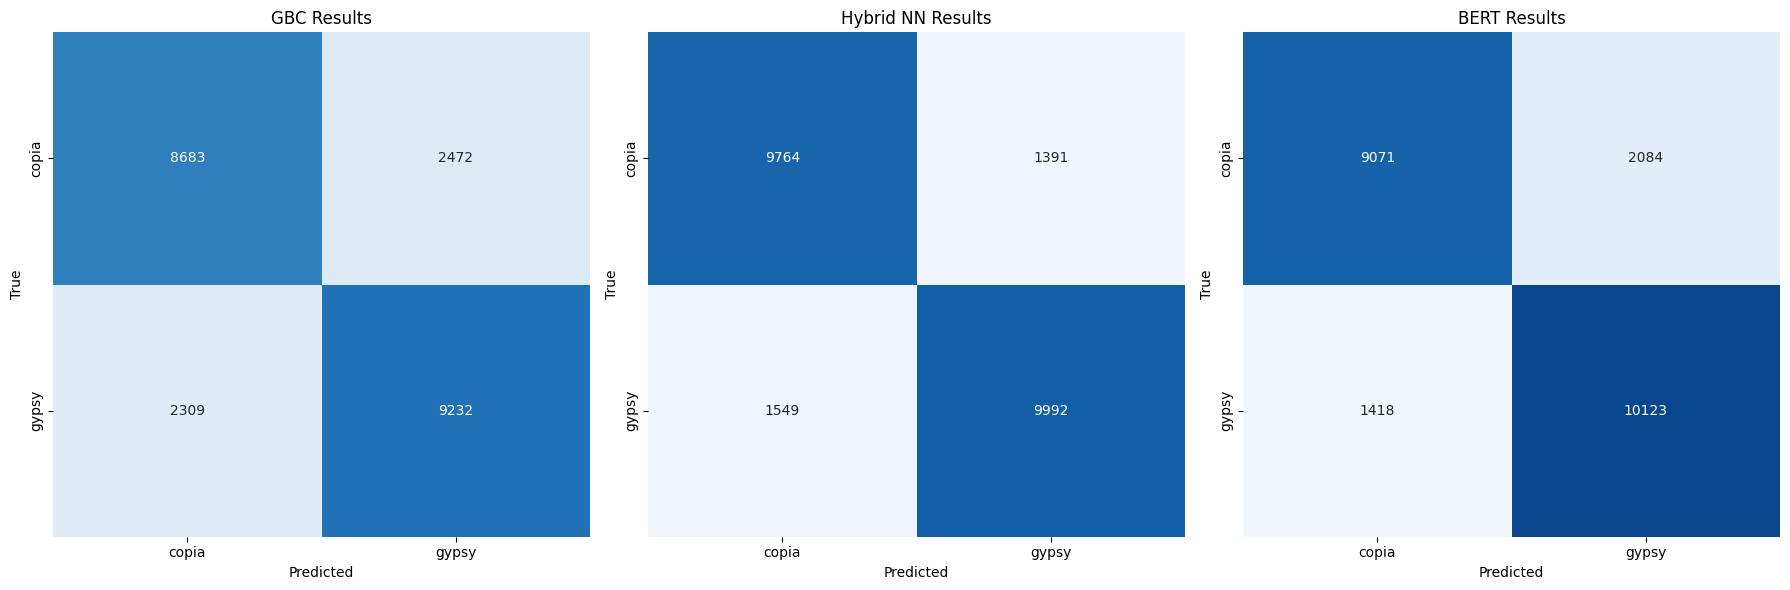

In [52]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate confusion matrix
cm = confusion_matrix(Y, GBC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=12000, vmin=1000)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticklabels(le.classes_)
axes[0].set_yticklabels(le.classes_)


cm = confusion_matrix(Y, Hybrid_NN_short_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=12000, vmin=1000)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticklabels(le.classes_)
axes[1].set_yticklabels(le.classes_)

# Calculate confusion matrix
cm = confusion_matrix(labels, BERT_short_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=11000, vmin=1000)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticklabels(le.classes_)
axes[2].set_yticklabels(le.classes_)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

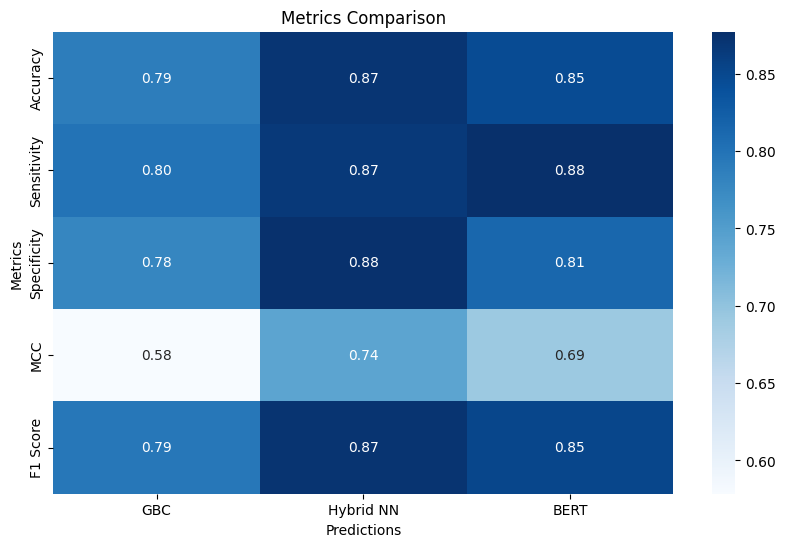

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score
import matplotlib.pyplot as plt
# Create a list of predictions and labels
y = labels
predictions = [GBC_predictions, Hybrid_NN_short_predictions, BERT_short_predictions]
names = ['GBC', 'Hybrid NN', 'BERT']

# Create a list to store the metrics
accuracy_list = []
sensitivity_list = []
specificity_list = []
mcc_list = []
roc_auc_list = []
f1_list = []

# Calculate the metrics for each prediction
for pred, n in zip(predictions, names):

    # Calculate accuracy
    accuracy = accuracy_score(y, pred)
    accuracy_list.append(accuracy)
    
    # Calculate sensitivity (recall)
    sensitivity = recall_score(y, pred)
    sensitivity_list.append(sensitivity)
    
    # Calculate specificity
    specificity = recall_score(y, pred, pos_label=0)
    specificity_list.append(specificity)
    
    # Calculate MCC
    mcc = matthews_corrcoef(y, pred)
    mcc_list.append(mcc)
    
    # Calculate F1 score
    f1 = f1_score(y, pred)
    f1_list.append(f1)

# Create a list of metric lists
metrics_list = [accuracy_list, sensitivity_list, specificity_list, mcc_list, f1_list]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_list, annot=True, cmap="Blues", fmt=".2f", xticklabels=names, yticklabels=['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'F1 Score'])
ax.set_title('Metrics Comparison')
ax.set_xlabel('Predictions')
ax.set_ylabel('Metrics')

# Show the plot
plt.show()


In [57]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for each model
fpr_hybrid, tpr_hybrid, _ = roc_curve(Y, Hybrid_NN_short_probas)
fpr_gbc, tpr_gbc, _ = roc_curve(Y, GBC_probas)
fpr_bert, tpr_bert, _ = roc_curve(labels, ...)

# Calculate the area under the ROC curve for each model
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label="Hybrid NN (area = %0.2f)" % roc_auc_hybrid)
plt.plot(fpr_gbc, tpr_gbc, label="GBC (area = %0.2f)" % roc_auc_gbc)
plt.plot(fpr_bert, tpr_bert, label="BERT (area = %0.2f)" % roc_auc_bert)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

InvalidParameterError: The 'y_score' parameter of roc_curve must be an array-like. Got Ellipsis instead.

## Test on medium sequences (512-2000bps)

In [36]:
# Load the sequences
MAX_LEN=4000
MIN_LEN=512

LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN and rec.description.split()[3] != "NAN"]
n_sequences = len(LTRs)
labels = [rec.description.split()[3] for rec in LTRs]
labels = list(le.transform(labels))


# Load the embedding classification network 
The embedding is a timely process so the sequences have been pre-embedded for the purposes of analysis.
If no embeddings are available, set ```create_embeddings=True```

In [18]:
#from classification_tools import avg_pool_embeddings
create_embeddings = False

#if create_embeddings:
#    avg_pool_embeddings()
#else:
embedded_test_sequences, labels, seq_ids = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Superfamily/BERT/LTRBERT_superfamily_classifier_embeddings_TEST.b_average", "rb"))

In [22]:
pooling_NN = tf.keras.models.load_model("/data/xhorvat9/ltr_bert/NewClassifiers/Superfamily/BERT/CNN_BERT_pool_model")
predicted_probas_BERT = pooling_NN.predict(new_embeds)
long_predictions = ((predicted_probas_BERT > 0.5)+0).ravel()

392/392 [==============================] - 1s 3ms/step


In [23]:
np.save("BERT_long_predictions.npy", long_predictions)
np.save("BERT_long_pred_probas.npy", predicted_probas_BERT)

In [19]:
label_df = pd.DataFrame({"ID": seq_ids, "class" : labels})
label_df.index = label_df["ID"]
print(len(label_df))
ltr_df = pd.DataFrame({"ID": [rec.id for rec in LTRs], "sequence" : [str(rec.seq) for rec in LTRs]}).set_index("ID")
ltr_df = ltr_df.join(label_df, how="inner")
print(len(ltr_df))
sequences = ltr_df["sequence"].tolist()

12568
12544


In [20]:
new_embeds = []

for seqid in tqdm.tqdm(list(ltr_df.index)):
    for embed_id, embedding in zip(seq_ids, embedded_test_sequences):
        if seqid == embed_id:
            new_embeds.append( embedding)
new_embeds = np.array(new_embeds)

100%|██████████| 12544/12544 [00:46<00:00, 268.48it/s]


In [71]:
len(long_predictions)

12568

In [78]:
len(Hybrid_NN_long_predictions)

12544

## Test hybrid NN model on long sequences 

In [26]:
sequences = [onehote(remove_N(str(rec.seq))) for rec in tqdm.tqdm(LTRs)]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="pre", maxlen=3000)
HNN_long_probas = all_seq_NN.predict(paddedDNA)
Hybrid_NN_long_predictions = ((HNN_long_probas > 0.5)+0).ravel()

  2%|▏         | 276/12544 [00:00<00:09, 1284.42it/s]

100%|██████████| 12544/12544 [00:09<00:00, 1268.16it/s]


392/392 [==============================] - 5s 13ms/step


In [32]:
np.save("NN_long_predictions.npy", Hybrid_NN_long_predictions)
np.save("NN_long_pred_probas.npy", HNN_long_probas)

## Test GBC on long sequences

In [ ]:
IDs = list(test_LTR_motifs.keys())
LTR_dt = pd.DataFrame(LTR_motif_dict_count, index=IDs)
data = LTR_dt
records = LTRs
rec_ids = pd.DataFrame({"ID": [rec.id for rec in records], "class": labels})
test_data_short = rec_ids.join(data, how = "inner", on = "ID")
Y = test_data_short["class"]
X = test_data_short.drop(["ID", "class"], axis=1)

In [37]:

labels = [rec.description.split()[3] for rec in LTRs]
labels = list(le.transform(labels))
rec_ids = pd.DataFrame({"ID": [rec.id for rec in LTRs], "class": labels})
test_data_long = rec_ids.join(data, how = "inner", on = "ID")
Y = test_data_long["class"]
X = test_data_long.drop(["ID", "class"], axis=1)

In [40]:
Y_long = Y

In [34]:
GBC_long_probas = GBC.predict_proba(X)[:, 1]
GBC_long_predictions = GBC.predict(X)

In [35]:
np.save("GBC_long_predict_probas.npy", GBC_long_probas)
np.save("GBC_long_predictions.npy", GBC_long_predictions)

In [15]:
import numpy as np
predicted_probas_BERT_long = np.load("BERT_long_pred_probas.npy")
HNN_long_probas = np.load("NN_long_pred_probas.npy")
GBC_predict_probas_long = np.load("GBC_long_predict_probas.npy")

predicted_probas_BERT_short = np.load("BERT_short_pred_probas.npy")
HNN_short_probas = np.load("NN_short_pred_probas.npy")
GBC_predict_probas_short = np.load("GBC_short_predict_probas.npy")

In [16]:
Y_all = np.load("Y_all.npy")

In [23]:
# Concatenate the arrays for each model
predicted_probas_BERT = np.concatenate((predicted_probas_BERT_long, predicted_probas_BERT_short[:, 1].reshape(-1, 1)))
HNN_probas = np.concatenate((HNN_long_probas, HNN_short_probas))
GBC_predict_probas = np.concatenate((GBC_predict_probas_long, GBC_predict_probas_short))

Y_all.shape[0] == predicted_probas_BERT.shape[0] == HNN_probas.shape[0] == RFC_predict_probas.shape[0]

True

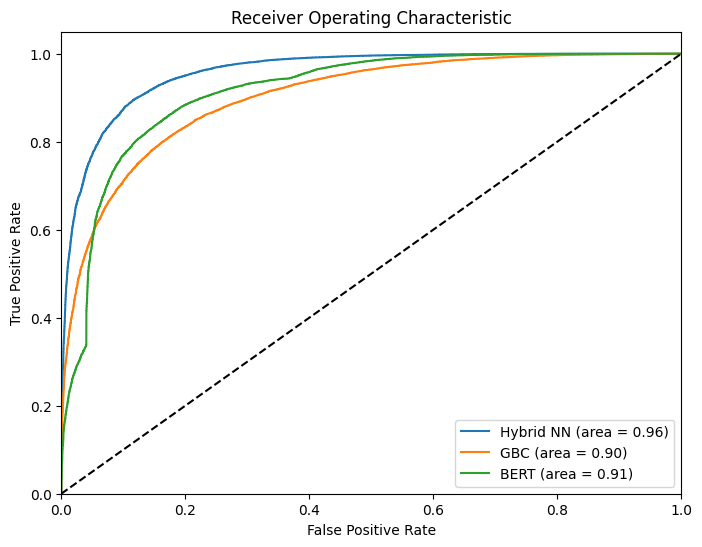

In [27]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for each model
fpr_hybrid, tpr_hybrid, _ = roc_curve(Y_all, HNN_probas)
fpr_gbc, tpr_gbc, _ = roc_curve(Y_all, GBC_predict_probas)
fpr_bert, tpr_bert, _ = roc_curve(Y_all, predicted_probas_BERT)

# Calculate the area under the ROC curve for each model
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label="Hybrid NN (area = %0.2f)" % roc_auc_hybrid)
plt.plot(fpr_gbc, tpr_gbc, label="GBC (area = %0.2f)" % roc_auc_gbc)
plt.plot(fpr_bert, tpr_bert, label="BERT (area = %0.2f)" % roc_auc_bert)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [51]:
BERT_predictions = ((predicted_probas_BERT > 0.5)+0).ravel()
Hybrid_NN_predictions = ((HNN_probas > 0.5)+0).ravel()
GBC_predictions = ((GBC_predict_probas > 0.5)+0).ravel()

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score
accuracy_score(Y_all, BERT_predictions)
recall_score(Y_all, BERT_predictions)

0.8702085682074409

In [61]:
print(classification_report(Y_all, pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     13952
           1       0.88      0.87      0.87     21288

    accuracy                           0.85     35240
   macro avg       0.84      0.84      0.84     35240
weighted avg       0.85      0.85      0.85     35240



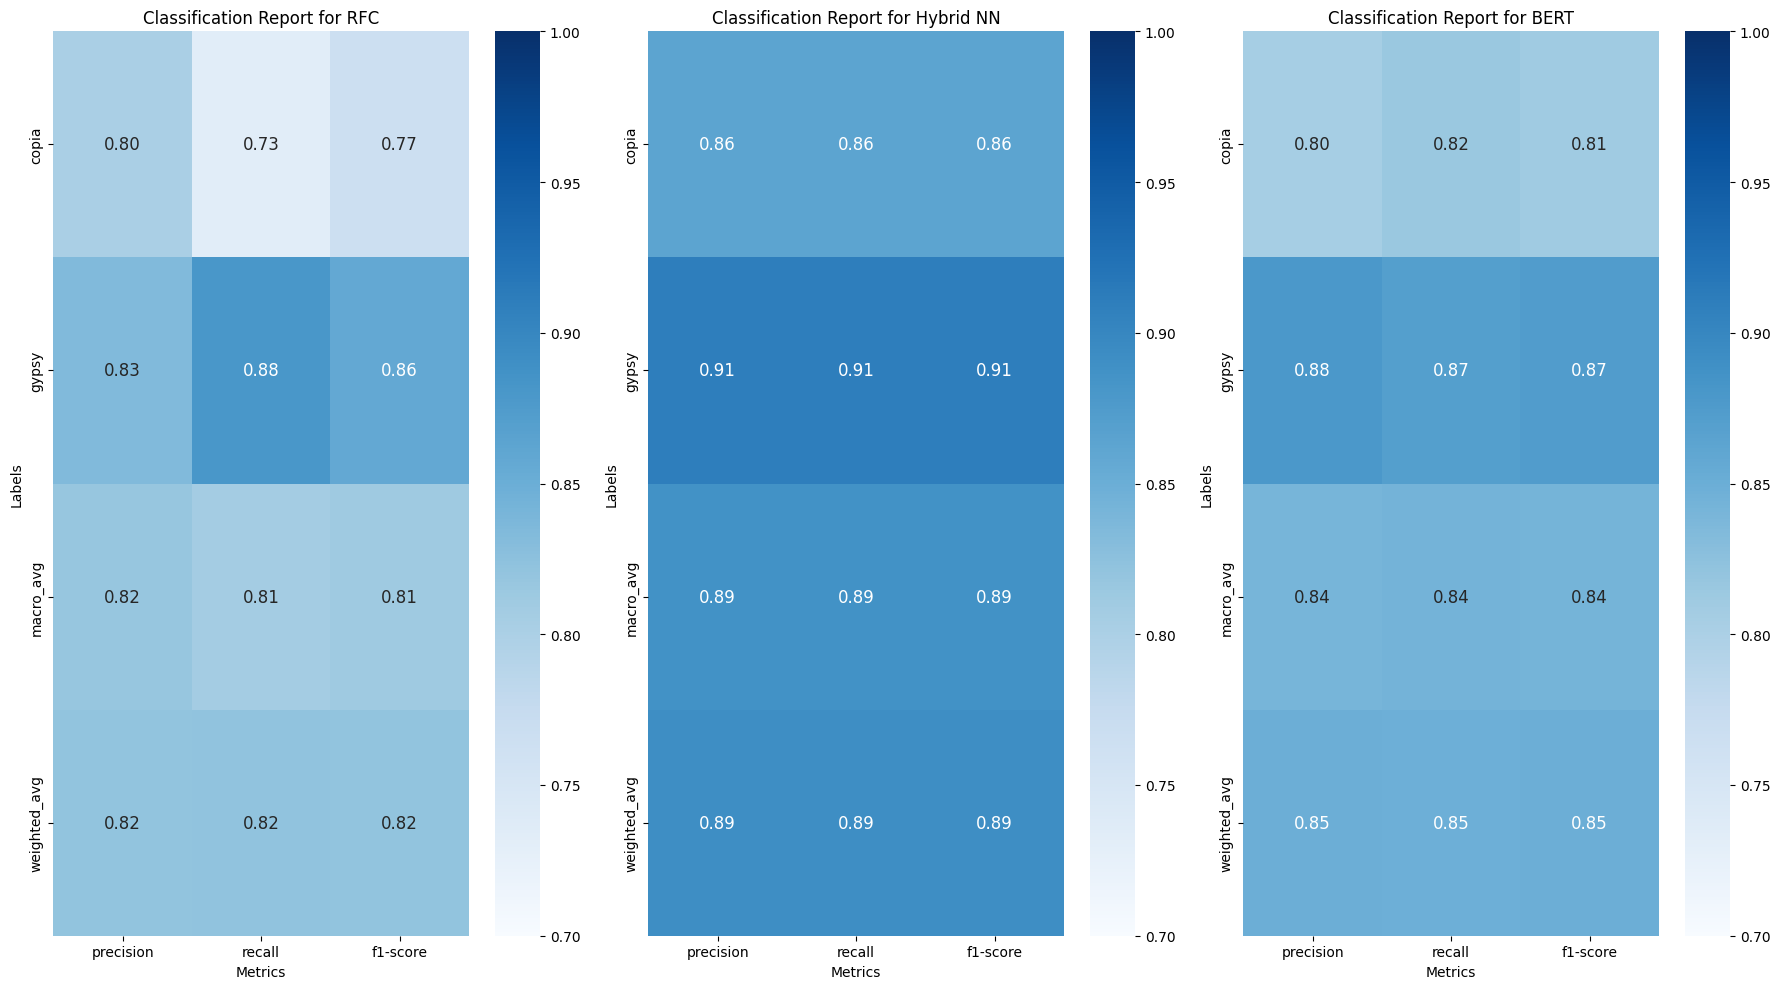

In [63]:
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
# Create a list of predictions and labels
predictions = [GBC_predictions, Hybrid_NN_predictions, BERT_predictions]
names = ['RFC', 'Hybrid NN', 'BERT']

# Create a list to store the classification reports
reports = []

# Generate the classification report for each prediction
for pred, name in zip(predictions, names):
    report = classification_report(Y_all, pred, output_dict=True)
    reports.append(report)

# Plot the classification reports
fig, axes = plt.subplots(1,len(reports), figsize=(6* len(reports), 10))

for i, report in enumerate(reports):
    rep = pd.DataFrame(report).drop("accuracy", axis=1)
    rep.columns = [le.inverse_transform([i])[0] for i in range(2)] + [ "macro_avg", "weighted_avg"]
    rep = rep.T
    rep = rep.drop("support", axis=1)
    #rep["support"] = rep["support"].astype(int)
    
    ax = axes[i]
    sns.heatmap(rep, annot=True, cmap="Blues", cbar=True, ax=ax, vmax=1, vmin=0.7, annot_kws={"size": 12}, fmt=".2f")
    ax.set_title(f"Classification Report for {names[i]}")
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Labels')

plt.tight_layout()
plt.show()


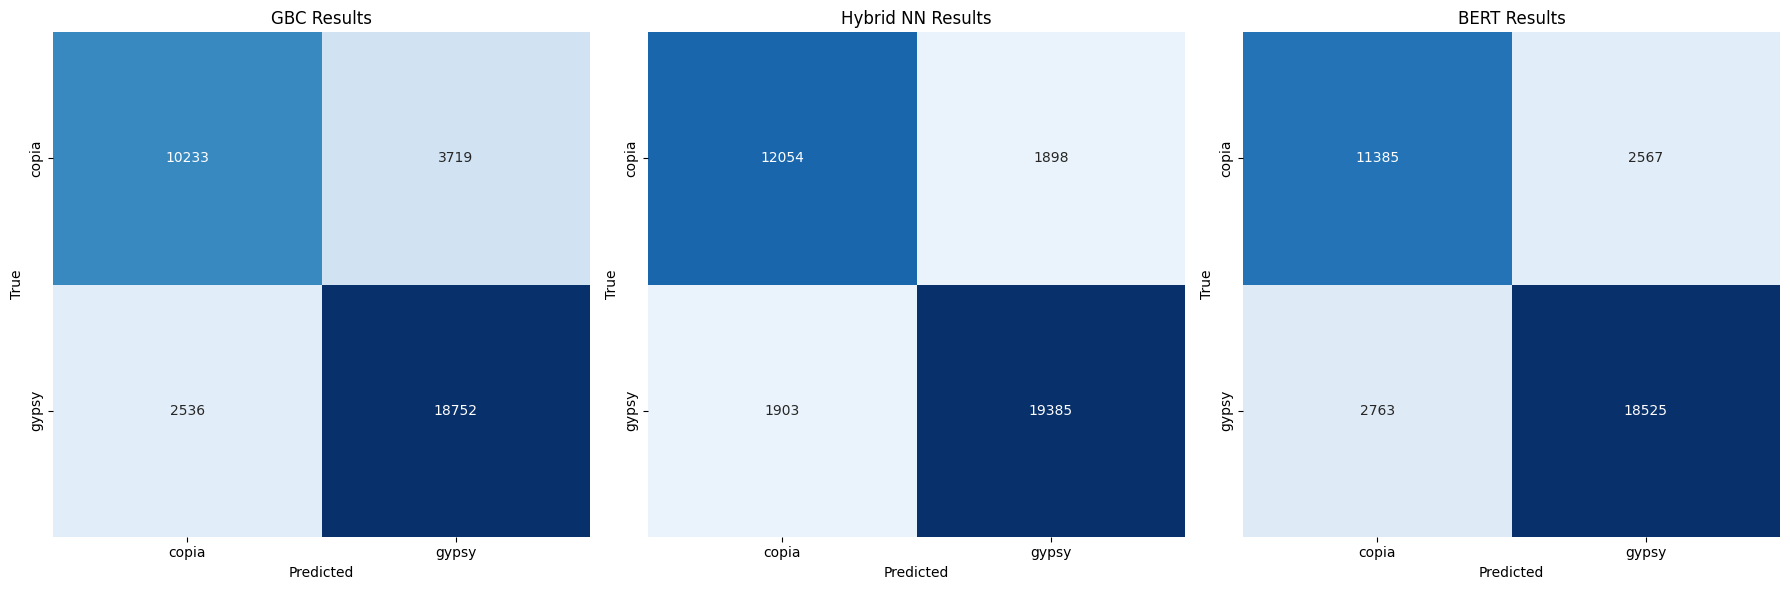

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


# Calculate confusion matrix
cm = confusion_matrix(Y_all, GBC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=15000, vmin=1000)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticklabels(le.classes_)
axes[0].set_yticklabels(le.classes_)


cm = confusion_matrix(Y_all, Hybrid_NN_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=15000, vmin=1000)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticklabels(le.classes_)
axes[1].set_yticklabels(le.classes_)

# Calculate confusion matrix
cm = confusion_matrix(Y_all, BERT_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=15000, vmin=1000)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticklabels(le.classes_)
axes[2].set_yticklabels(le.classes_)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

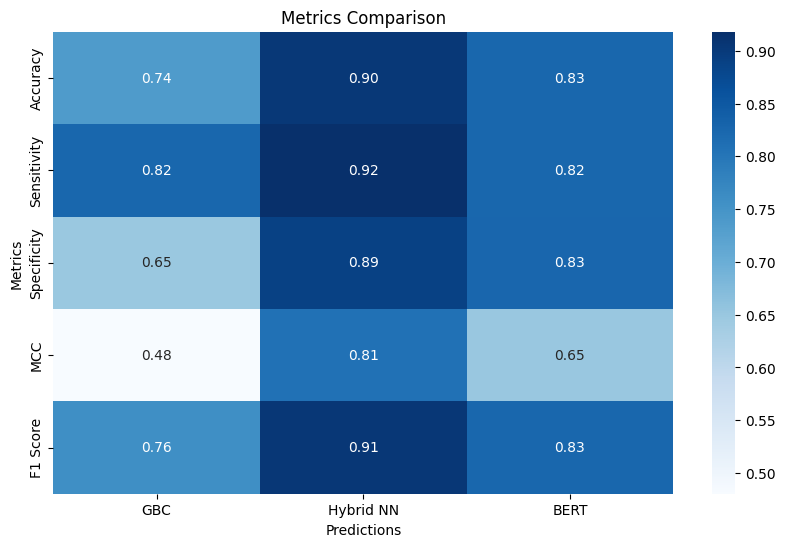

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score
import matplotlib.pyplot as plt
# Create a list of predictions and labels
Y = [0]*len(non_LTRs) + [1]*len(LTRs)
predictions = [GBC_predictions, Hybrid_NN_long_predictions, long_predictions]
names = ['GBC', 'Hybrid NN', 'BERT']

# Create a list to store the metrics
accuracy_list = []
sensitivity_list = []
specificity_list = []
mcc_list = []
roc_auc_list = []
f1_list = []

# Calculate the metrics for each prediction
for pred, n in zip(predictions, names):
    if n == 'BERT':
        y = labels
    else:
        y = Y
    # Calculate accuracy
    accuracy = accuracy_score(y, pred)
    accuracy_list.append(accuracy)
    
    # Calculate sensitivity (recall)
    sensitivity = recall_score(y, pred)
    sensitivity_list.append(sensitivity)
    
    # Calculate specificity
    specificity = recall_score(y, pred, pos_label=0)
    specificity_list.append(specificity)
    
    # Calculate MCC
    mcc = matthews_corrcoef(y, pred)
    mcc_list.append(mcc)
    
    # Calculate F1 score
    f1 = f1_score(y, pred)
    f1_list.append(f1)

# Create a list of metric lists
metrics_list = [accuracy_list, sensitivity_list, specificity_list, mcc_list, f1_list]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_list, annot=True, cmap="Blues", fmt=".2f", xticklabels=names, yticklabels=['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'F1 Score'])
ax.set_title('Metrics Comparison')
ax.set_xlabel('Predictions')
ax.set_ylabel('Metrics')

# Show the plot
plt.show()


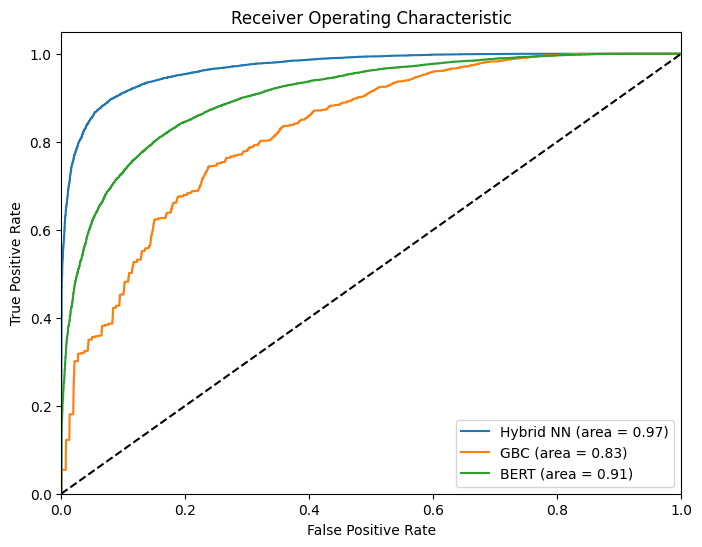

In [67]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for each model
fpr_hybrid, tpr_hybrid, _ = roc_curve(Y, HNN_long_probas)
fpr_gbc, tpr_gbc, _ = roc_curve(Y, GBC.predict_proba(X)[:, 1])
fpr_bert, tpr_bert, _ = roc_curve(labels, predicted_probas_BERT)

# Calculate the area under the ROC curve for each model
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label="Hybrid NN (area = %0.2f)" % roc_auc_hybrid)
plt.plot(fpr_gbc, tpr_gbc, label="GBC (area = %0.2f)" % roc_auc_gbc)
plt.plot(fpr_bert, tpr_bert, label="BERT (area = %0.2f)" % roc_auc_bert)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()